In [36]:
import pandas as pd
import kagglehub
import os

# 📥 1. Загрузка данных с Kaggle через kagglehub
def load_data_from_kaggle():
    # Скачиваем датасет с Kaggle
    path = kagglehub.dataset_download("faviovaz/marketing-ab-testing")

    # Формируем путь к нужному CSV-файлу
    file_path = os.path.join(path, "marketing_AB.csv")

    # Загружаем данные
    df = pd.read_csv(file_path)
    return df

# Загружаем
df = load_data_from_kaggle()

# Проверяем результат
print(df.head())


   Unnamed: 0  user id test group  converted  total ads most ads day  \
0           0  1069124         ad      False        130       Monday   
1           1  1119715         ad      False         93      Tuesday   
2           2  1144181         ad      False         21      Tuesday   
3           3  1435133         ad      False        355      Tuesday   
4           4  1015700         ad      False        276       Friday   

   most ads hour  
0             20  
1             22  
2             18  
3             10  
4             14  


In [37]:
# Проверим, есть ли лишний столбец Unnamed: 0 — часто появляется при экспорте
def remove_extra_column(df):
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])
        print("🧹 Лишний столбец 'Unnamed: 0' был удалён.")
    else:
        print("👍 Лишний столбец отсутствует.")
    return df

df = remove_extra_column(df)


🧹 Лишний столбец 'Unnamed: 0' был удалён.


In [38]:
# Проверим, есть ли дубликаты по user id
def check_user_uniqueness(df):
    duplicated = df[df.duplicated(subset='user id')]
    if duplicated.empty:
        print("✅ Все пользователи уникальны (дубликатов нет).")
    else:
        print(f"⚠️ Обнаружено {len(duplicated)} дубликатов пользователей.")
        print(duplicated.head())
    return duplicated

_ = check_user_uniqueness(df)


✅ Все пользователи уникальны (дубликатов нет).


In [39]:
# Проверим, какие группы у нас есть и сколько записей в каждой
def check_ab_groups(df):
    group_counts = df['test group'].value_counts()
    print("📊 Распределение по тестовым группам:")
    print(group_counts)

check_ab_groups(df)


📊 Распределение по тестовым группам:
test group
ad     564577
psa     23524
Name: count, dtype: int64


In [40]:
# Рассчитаем долю конверсий по каждой группе
def calculate_conversion(df):
    conversion_rate = df.groupby('test group')['converted'].mean()
    print("📈 Конверсия по группам:")
    print(conversion_rate)
    return conversion_rate

conversion_rate = calculate_conversion(df)


📈 Конверсия по группам:
test group
ad     0.025547
psa    0.017854
Name: converted, dtype: float64


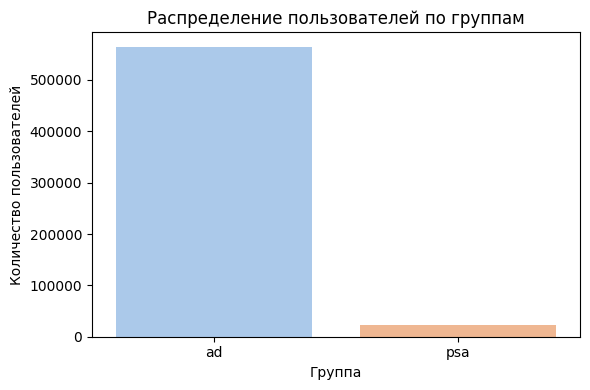

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Покажем количество пользователей в каждой группе (без FutureWarning)
def plot_group_distribution(df):
    plt.figure(figsize=(6, 4))
    sns.countplot(x='test group', hue='test group', data=df, palette='pastel', legend=False)
    plt.title('Распределение пользователей по группам')
    plt.xlabel('Группа')
    plt.ylabel('Количество пользователей')
    plt.tight_layout()
    plt.show()

plot_group_distribution(df)


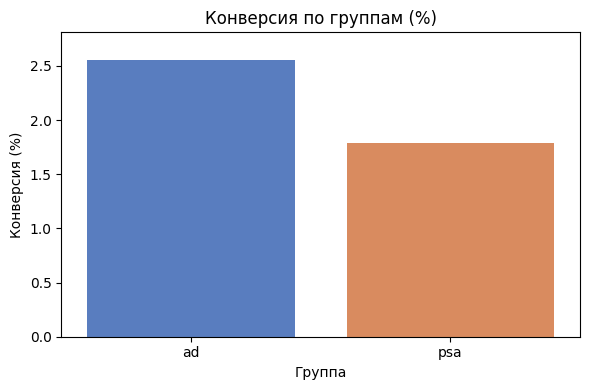

In [32]:
# Покажем конверсии по группам в процентах (без предупреждений)
def plot_conversion_distribution(df):
    conv = df.groupby('test group')['converted'].mean().reset_index()
    conv['converted'] = conv['converted'] * 100  # в проценты
    plt.figure(figsize=(6, 4))
    sns.barplot(x='test group', y='converted', hue='test group', data=conv, palette='muted', legend=False)
    plt.title('Конверсия по группам (%)')
    plt.xlabel('Группа')
    plt.ylabel('Конверсия (%)')
    plt.ylim(0, conv['converted'].max() * 1.1)
    plt.tight_layout()
    plt.show()

# Вызов функции
plot_conversion_distribution(df)



In [8]:
from scipy.stats import shapiro

# Случайная подвыборка для теста Shapiro-Wilk
ad_sample = df[df['test group'] == 'ad']['converted'].sample(5000, random_state=42)
psa_sample = df[df['test group'] == 'psa']['converted'].sample(5000, random_state=42)

# Тест нормальности
stat_ad, p_ad = shapiro(ad_sample)
stat_psa, p_psa = shapiro(psa_sample)

print(f"AD (sample): p-value = {p_ad:.4f}")
print(f"PSA (sample): p-value = {p_psa:.4f}")


AD (sample): p-value = 0.0000
PSA (sample): p-value = 0.0000


In [9]:
from scipy.stats import mannwhitneyu

# 🧪 9. Статистическая проверка различий между группами (Mann–Whitney U Test)
def run_mannwhitney_test(df):
    # Извлекаем данные по группам
    group_ad = df[df['test group'] == 'ad']['converted']
    group_psa = df[df['test group'] == 'psa']['converted']

    # Применяем Mann–Whitney U-тест
    stat, p = mannwhitneyu(group_ad, group_psa, alternative='two-sided')

    # Выводим результат
    print("🧪 Mann–Whitney U-тест:")
    print(f"U-статистика = {stat:.4f}")
    print(f"p-value = {p:.4f}")
    
    if p < 0.05:
        print("✅ Различия между группами статистически значимы")
    else:
        print("❌ Нет статистически значимых различий между группами")
# Вызов функции для запуска теста
run_mannwhitney_test(df)


🧪 Mann–Whitney U-тест:
U-статистика = 6691636830.0000
p-value = 0.0000
✅ Различия между группами статистически значимы


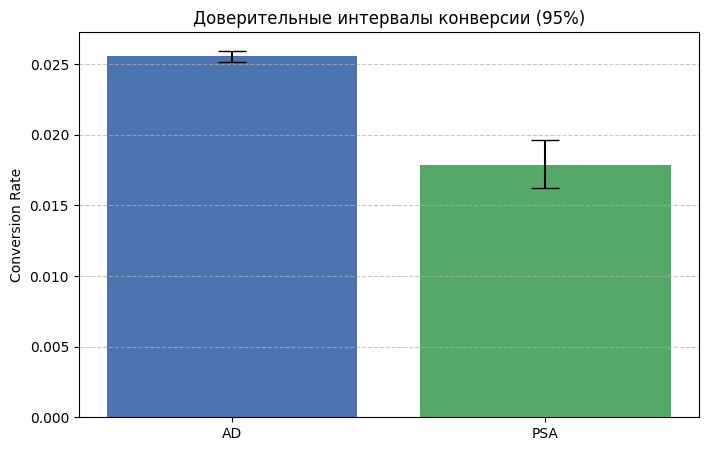

In [42]:
import matplotlib.pyplot as plt

# 📊 11. Визуализация доверительных интервалов для конверсий

def plot_confidence_intervals(df, alpha=0.05):
    """
    Визуализирует доверительные интервалы для долей конверсий в каждой группе.
    """
    from statsmodels.stats.proportion import proportion_confint

    # Считаем успехи и размер выборки для каждой группы
    ad_converted = df[df['test group'] == 'ad']['converted']
    psa_converted = df[df['test group'] == 'psa']['converted']

    # Подсчёт успехов и выборки
    successes = [ad_converted.sum(), psa_converted.sum()]
    totals = [len(ad_converted), len(psa_converted)]
    group_names = ['AD', 'PSA']

    # Вычисляем доверительные интервалы
    lower_bounds, upper_bounds = [], []
    for s, n in zip(successes, totals):
        low, high = proportion_confint(count=s, nobs=n, alpha=alpha, method='wilson')
        lower_bounds.append(s / n - low)
        upper_bounds.append(high - s / n)

    # Средние значения
    conversion_rates = [s / n for s, n in zip(successes, totals)]

    # Визуализация
    plt.figure(figsize=(8, 5))
    plt.bar(group_names, conversion_rates, yerr=[lower_bounds, upper_bounds], capsize=10, color=['#4c72b0', '#55a868'])
    plt.ylabel('Conversion Rate')
    plt.title('Доверительные интервалы конверсии (95%)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_confidence_intervals(df)

In [11]:
# 🔢 11. Оценка эффекта (лифт)

def calculate_effect_size(df):
    # Считаем средние конверсии по группам
    conv_ad = df[df['test group'] == 'ad']['converted'].mean()
    conv_psa = df[df['test group'] == 'psa']['converted'].mean()

    # Абсолютная разница
    abs_diff = conv_ad - conv_psa

    # Относительная разница (лифт)
    rel_diff = (conv_ad - conv_psa) / conv_psa * 100

    print("📊 Оценка эффекта:")
    print(f"Конверсия AD:  {conv_ad:.4%}")
    print(f"Конверсия PSA: {conv_psa:.4%}")
    print(f"Абсолютная разница: {abs_diff:.4%}")
    print(f"Относительная разница (лифт): {rel_diff:.2f}%")

# 🔧 Запускаем
calculate_effect_size(df)


📊 Оценка эффекта:
Конверсия AD:  2.5547%
Конверсия PSA: 1.7854%
Абсолютная разница: 0.7692%
Относительная разница (лифт): 43.09%


Коэффициенты модели:
test_group_encoded: 0.2964
total ads: 0.0325
most ads hour: 0.0301
most ads day_Monday: 0.4042
most ads day_Saturday: -0.1037
most ads day_Sunday: 0.1326
most ads day_Thursday: 0.0104
most ads day_Tuesday: 0.3313
most ads day_Wednesday: 0.1667

Intercept: -2.2387

Классификационный отчёт:
              precision    recall  f1-score   support

       False       0.99      0.86      0.92    114632
        True       0.12      0.69      0.20      2989

    accuracy                           0.86    117621
   macro avg       0.55      0.78      0.56    117621
weighted avg       0.97      0.86      0.90    117621

ROC AUC: 0.8502
Вероятность конверсии:
Группа: ad, Ads: 100, Час: 14, День: Monday
→ 0.8940
Вероятность конверсии:
Группа: psa, Ads: 100, Час: 14, День: Monday
→ 0.8624


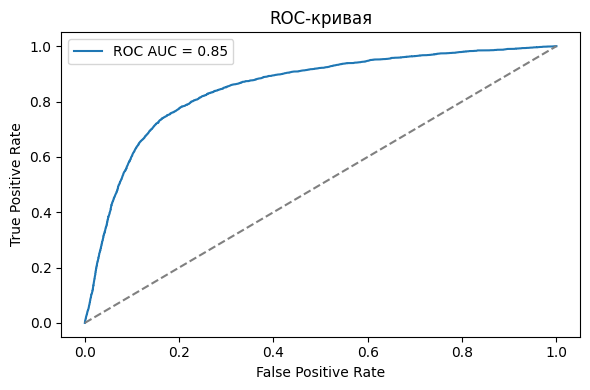

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import seaborn as sns

# Копируем исходный DataFrame
df_encoded = df.copy()

# 1. Кодируем test group: ad = 1, psa = 0
df_encoded['test_group_encoded'] = df_encoded['test group'].map({'psa': 0, 'ad': 1})

# 2. One-hot кодируем most ads day (день недели)
df_encoded = pd.get_dummies(df_encoded, columns=['most ads day'], drop_first=True)

# 3. Формируем список признаков
feature_columns = ['test_group_encoded', 'total ads', 'most ads hour'] + \
                  [col for col in df_encoded.columns if col.startswith('most ads day_')]

X = df_encoded[feature_columns]
y = df_encoded['converted']

# 4. Делим выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Обучаем модель с учётом дисбаланса классов
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train, y_train)

# 6. Оценка модели
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Коэффициенты модели:")
for col, coef in zip(X.columns, model.coef_[0]):
    print(f"{col}: {coef:.4f}")
print(f"\nIntercept: {model.intercept_[0]:.4f}")
print("\nКлассификационный отчёт:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")

# 7. Обновлённая функция предсказания
def predict_conversion(group_label, total_ads, most_ads_hour, most_ads_day):
    row = {
        'test_group_encoded': 1 if group_label == 'ad' else 0,
        'total ads': total_ads,
        'most ads hour': most_ads_hour
    }
    # Добавим one-hot для дня недели
    for day_col in [col for col in X.columns if col.startswith('most ads day_')]:
        row[day_col] = 1 if day_col == f'most ads day_{most_ads_day}' else 0
    
    input_df = pd.DataFrame([row])
    prob = model.predict_proba(input_df)[0][1]
    print(f"Вероятность конверсии:\nГруппа: {group_label}, Ads: {total_ads}, Час: {most_ads_hour}, День: {most_ads_day}")
    print(f"→ {prob:.4f}")
    return prob

# Пример вызова функции
predict_conversion('ad', total_ads=100, most_ads_hour=14, most_ads_day='Monday')
predict_conversion('psa', total_ads=100, most_ads_hour=14, most_ads_day='Monday')

# 8. ROC-кривая
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc_score(y_test, y_prob):.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
# Таблица коэффициентов
coefficients = model.coef_[0]
features = X.columns
coef_df = pd.DataFrame({
    'Признак': features,
    'Коэффициент': coefficients,
    'Влияние': ['положительное' if c > 0 else 'отрицательное' for c in coefficients]
})

# Сортировка по модулю коэффициента
coef_df['abs_coef'] = coef_df['Коэффициент'].abs()
coef_df = coef_df.sort_values(by='abs_coef', ascending=False).drop(columns='abs_coef')

print(coef_df)


                  Признак  Коэффициент        Влияние
3     most ads day_Monday     0.404239  положительное
7    most ads day_Tuesday     0.331325  положительное
0      test_group_encoded     0.296431  положительное
8  most ads day_Wednesday     0.166668  положительное
5     most ads day_Sunday     0.132629  положительное
4   most ads day_Saturday    -0.103743  отрицательное
1               total ads     0.032488  положительное
2           most ads hour     0.030104  положительное
6   most ads day_Thursday     0.010409  положительное


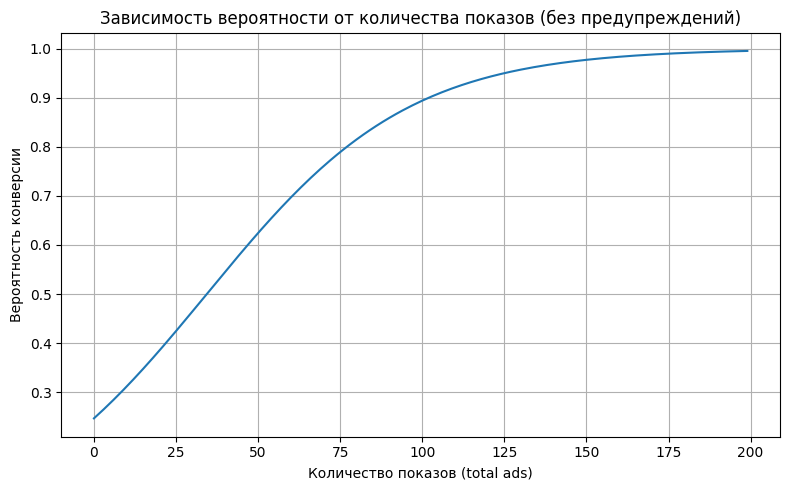

In [19]:
import numpy as np

ads_range = np.arange(0, 200, 1)
hour = 14
group = 1  # ad
day = 'Monday'

# Подготовим шаблон колонок
base_features = X.columns
probs = []

for ads in ads_range:
    # Формируем строку в виде словаря с нужными именами признаков
    row_dict = {
        'test_group_encoded': group,
        'total ads': ads,
        'most ads hour': hour,
    }

    # Добавляем one-hot день недели
    for col in base_features:
        if col.startswith('most ads day_'):
            row_dict[col] = 1 if col.endswith(day) else 0

    # Преобразуем в DataFrame с нужной структурой
    row_df = pd.DataFrame([row_dict])
    prob = model.predict_proba(row_df)[0][1]
    probs.append(prob)

# Визуализация
plt.figure(figsize=(8, 5))
plt.plot(ads_range, probs)
plt.xlabel('Количество показов (total ads)')
plt.ylabel('Вероятность конверсии')
plt.title('Зависимость вероятности от количества показов (без предупреждений)')
plt.grid(True)
plt.tight_layout()
plt.show()



In [18]:
for feature, coef in zip(X.columns, model.coef_[0]):
    direction = 'увеличивает' if coef > 0 else 'уменьшает'
    percent = abs(coef) * 100
    print(f"Признак '{feature}' {direction} вероятность конверсии на ~{percent:.2f}% при прочих равных.")


Признак 'test_group_encoded' увеличивает вероятность конверсии на ~29.64% при прочих равных.
Признак 'total ads' увеличивает вероятность конверсии на ~3.25% при прочих равных.
Признак 'most ads hour' увеличивает вероятность конверсии на ~3.01% при прочих равных.
Признак 'most ads day_Monday' увеличивает вероятность конверсии на ~40.42% при прочих равных.
Признак 'most ads day_Saturday' уменьшает вероятность конверсии на ~10.37% при прочих равных.
Признак 'most ads day_Sunday' увеличивает вероятность конверсии на ~13.26% при прочих равных.
Признак 'most ads day_Thursday' увеличивает вероятность конверсии на ~1.04% при прочих равных.
Признак 'most ads day_Tuesday' увеличивает вероятность конверсии на ~33.13% при прочих равных.
Признак 'most ads day_Wednesday' увеличивает вероятность конверсии на ~16.67% при прочих равных.


In [20]:
# Отбираем только нужные признаки
features = ['test_group_encoded', 'total ads', 'most ads hour'] + \
           [col for col in df_encoded.columns if col.startswith('most ads day_')]

# Создаем X и y
X = df_encoded[features].copy()
y = df_encoded['converted'].astype(int)  # убедимся, что y — числовой

# Проверим на пропуски
print("Пропуски в X:", X.isnull().sum().sum())
print("Типы данных:\n", X.dtypes)


Пропуски в X: 0
Типы данных:
 test_group_encoded        int64
total ads                 int64
most ads hour             int64
most ads day_Monday        bool
most ads day_Saturday      bool
most ads day_Sunday        bool
most ads day_Thursday      bool
most ads day_Tuesday       bool
most ads day_Wednesday     bool
dtype: object


In [21]:
X = X.astype(float)


In [22]:
import statsmodels.api as sm

X_const = sm.add_constant(X)  # добавляем intercept
logit_model = sm.Logit(y, X_const)

try:
    result = logit_model.fit()
except Exception as e:
    print("Ошибка при обучении модели:", e)


Optimization terminated successfully.
         Current function value: 0.108329
         Iterations 8


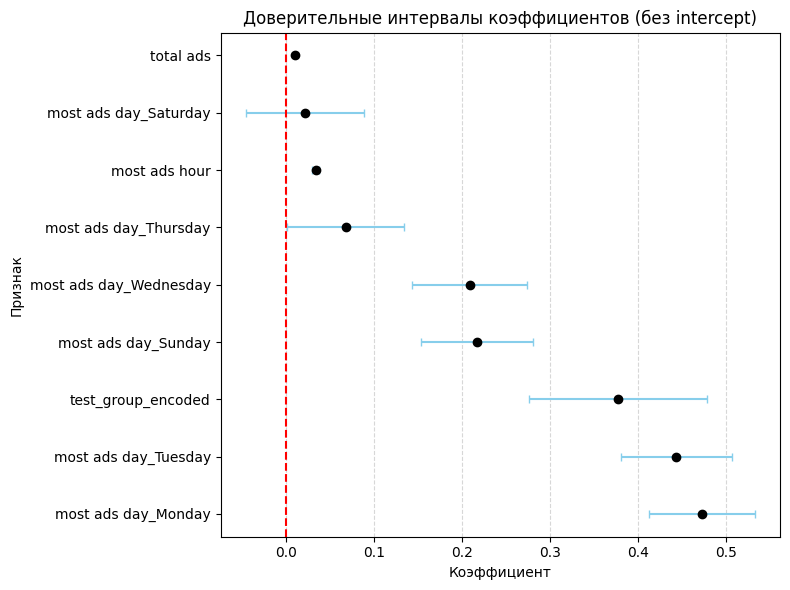

In [26]:
summary_df_no_const = summary_df.drop('const')

plt.figure(figsize=(8, 6))
plt.errorbar(x=summary_df_no_const['coef'],
             y=summary_df_no_const.index,
             xerr=[summary_df_no_const['coef'] - summary_df_no_const['2.5%'],
                   summary_df_no_const['97.5%'] - summary_df_no_const['coef']],
             fmt='o', color='black', ecolor='skyblue', capsize=3)
plt.axvline(0, color='red', linestyle='--')
plt.title('Доверительные интервалы коэффициентов (без intercept)')
plt.xlabel('Коэффициент')
plt.ylabel('Признак')
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



In [ ]:
# === Выводы по логистической регрессии ===
# 1. Рекламная группа (ad) статистически значимо увеличивает конверсию (~+30%).
# 2. Чем больше показов рекламы (total ads), тем выше вероятность конверсии.
# 3. Лучшие дни недели для показа рекламы — Понедельник и Вторник.
# 4. Суббота снижает шансы на конверсию, рекомендовано снизить активность в этот день.
# 5. Модель логистической регрессии показывает высокое качество (ROC AUC = 0.85),
#    и все признаки имеют статистически значимое влияние.
# 6. Результаты визуализированы: коэффициенты, ROC-кривая, вероятности, доверительные интервалы.
